In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
from glob import glob
from datetime import datetime, timezone
# import os
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [2]:
# Get and sort all files
filelist = sorted(glob('/data/fast0/kamchatka/*/*hdf5'))

datas = []
datetimes_list = []

dt = None
dx = None
x = None

for fname in filelist:
    with h5py.File(fname, 'r') as datafile:
        # Read data
        das_i = np.array(datafile['/data'])   # shape: (nt_i, nx)
        nt_i, nx_i = das_i.shape
        datas.append(das_i)

        # Only need to read these once (assuming all files share dt, dx, nx)
        if dt is None:
            dt = float(np.array(datafile['/header/dt']))
            dx = float(np.array(datafile['/header/dx']))
            nx = nx_i
            x = np.linspace(0, nx * dx, nx)

        # Time info for this file
        start_time = float(np.array(datafile['/header/time']))
        t_local = np.arange(nt_i) * dt  # time within this file

        # Datetimes for this file
        datetimes_i = [
            datetime.fromtimestamp(start_time + ti, tz=timezone.utc)
            for ti in t_local
        ]
        datetimes_list.extend(datetimes_i)

# Concatenate all data along time axis
das = np.concatenate(datas, axis=0)   # shape: (nt_total, nx)
nt_total = das.shape[0]

# Global time vector starting from 0
t = np.arange(nt_total) * dt

# Concatenated datetime array
datetimes = np.array(datetimes_list)

print(datetimes[0], datetimes[-1])


2025-07-29 23:00:08.776000+00:00 2025-07-30 04:00:08.756000+00:00


In [3]:
# TODO: from somewheres about here we should be able to extract the spatial decimation
# list(datafile['/processingChain/step-1/'])
decimation_factor = 10  # example value
dx = dx * decimation_factor
x = x * decimation_factor

In [4]:
# Option: decimate in time for faster plotting
decimation_factor_time = 2
data_filt = das[::decimation_factor_time,:]
datetimes = datetimes[::decimation_factor_time]
t = t[::decimation_factor_time]

# Optional: Lowpass filter the data
b,a = butter(2,10,'lowpass',fs=1/dt)
data_filt = filtfilt(b,a,data_filt,axis=0)



# data_filt = das

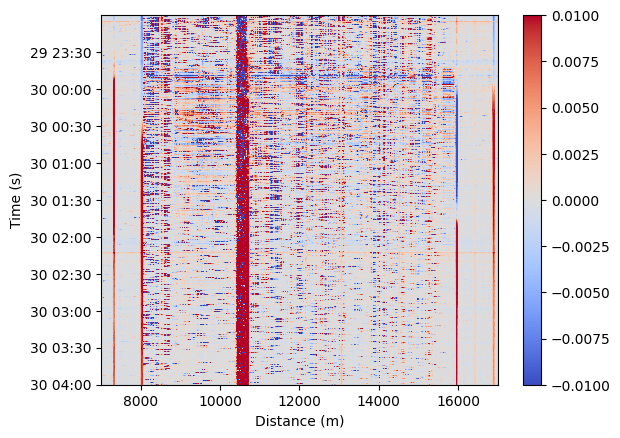

In [8]:
vm = 0.01
plt.subplots()
c=plt.imshow(data_filt,aspect='auto',cmap='coolwarm',
             vmin=-vm,vmax=vm,extent=[x[0],x[-1],datetimes[-1],datetimes[0]])
plt.colorbar(c)
plt.xlabel('Distance (m)')
plt.ylabel('Time (s)')

# add another x axis on top with channel numbers
# ax = plt.gca()
# ax2 = ax.twiny()
# ax2.set_xlim(ax.get_xlim())
# ax2.set_xticks(x[::500])
# ax2.set_xticklabels(np.arange(0, nx, 500))
# ax2.set_xlabel('Channel number')

# plt.xlim([0,30000])
plt.xlim([7000,17000])
plt.show()